In [1]:
%load_ext autoreload
%autoreload 2

%config IPCompleter.greedy=True

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from astropy import units

import importlib

import snapshot_obj
import simulation_tracing
import dataset_compute
import subhalo

In [35]:
importlib.reload(snapshot_obj)
importlib.reload(simulation_tracing)
importlib.reload(dataset_compute)
importlib.reload(subhalo)

<module 'subhalo' from '/home/kasper/Curvaton_Simulations/APOSTLE_analysis/subhalo.py'>

# Plotting trajectories of halos

## Tracing a satellite

In [82]:
sim_id = "V1_MR_fix"
start = 127; stop = 100

First, identify the central halo through snapshots:

In [83]:
gn=1
snap_z0 = snapshot_obj.Snapshot(sim_id, start)
sim_tracer = simulation_tracing.SimulationTracer(snap_z0)
sim_trace, snap_ids = sim_tracer.trace_all(stop=100)

In [84]:
central = subhalo.Subhalo(snap_z0, gn, 0, (sim_trace, snap_ids))

Then, select a satellite that can be traced back through a couple snapshots (for instance, the M31 satellite (1,4)):

In [103]:
gn=1; sgn=9
satellite = subhalo.Subhalo(snap_z0, gn, sgn, (sim_trace, snap_ids))
for i, sid in zip(satellite.tracer[0], satellite.tracer[1]):
    print(sid, i)

100 3
101 3
102 1
103 1
104 2
105 2
106 1279
107 1336
108 1342
109 1366
110 1406
111 1
112 1
113 1
114 2
115 3
116 3
117 3
118 3
119 3
120 3
121 2
122 2
123 2
124 6
125 7
126 8
127 9


Compute the distance between the central and the satellite:

In [104]:
%time d = np.array([satellite.distance_to_central(sid, central) \
                    for sid in snap_ids]).reshape(snap_ids.size,3)
d = d * units.cm.to(units.kpc)

CPU times: user 4.78 s, sys: 434 ms, total: 5.21 s
Wall time: 5.67 s


Plot in the xy- and xz-plane:

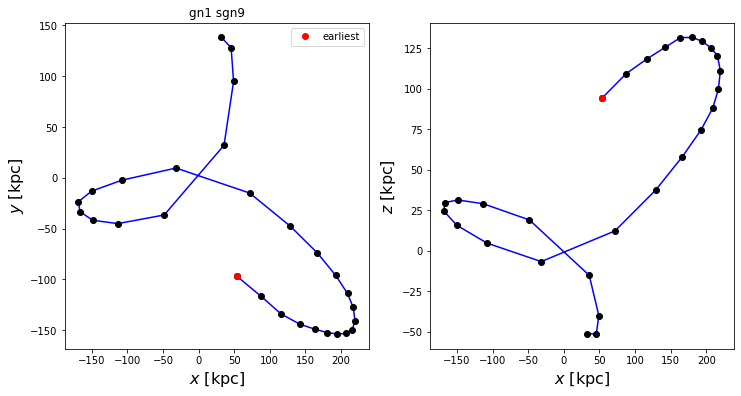

In [105]:
fig,ax = plt.subplots(ncols=2, figsize=(12,6))

ax[0].set_title('gn{} sgn{}'.format(gn,sgn))

ax[0].plot(d[:,0], d[:,1], 'b')
ax[0].plot(d[:,0], d[:,1], 'ko')
ax[0].plot(d[0,0], d[0,1], 'ro', label='earliest')
ax[0].set_xlabel('$x$ [kpc]', fontsize=16)
ax[0].set_ylabel('$y$ [kpc]', fontsize=16)

ax[1].plot(d[:,0], d[:,2], 'b')
ax[1].plot(d[:,0], d[:,2], 'ko')
ax[1].plot(d[0,0], d[0,2], 'ro')
ax[1].set_xlabel('$x$ [kpc]', fontsize=16)
ax[1].set_ylabel('$z$ [kpc]', fontsize=16)

ax[0].legend()

# Save figure:

filename = 'satellite_trajectory_gn{}sgn{}_{}.png'.format(gn,sgn,sim_id)

home = os.path.dirname(snapshot_obj.__file__)
path = os.path.join(home,"Figures",sim_id)

# If the directory does not exist, create it
if not os.path.exists(path):
    os.makedirs(path)
plt.savefig(os.path.join(path,filename), dpi=200)

# Plot evolution of mass components

In [106]:
z = np.zeros(snap_ids.size)
for i,sid in enumerate(snap_ids):
    z[i] = snapshot_obj.Snapshot(sim_id, sid).get_attribute('Redshift', 'Header')

In [107]:
masses = np.zeros((snap_ids.size, 6))
for i,sid in enumerate(snap_ids):
    masses[i] = satellite.get_halo_data("MassType", sid) * units.g.to(units.Msun)

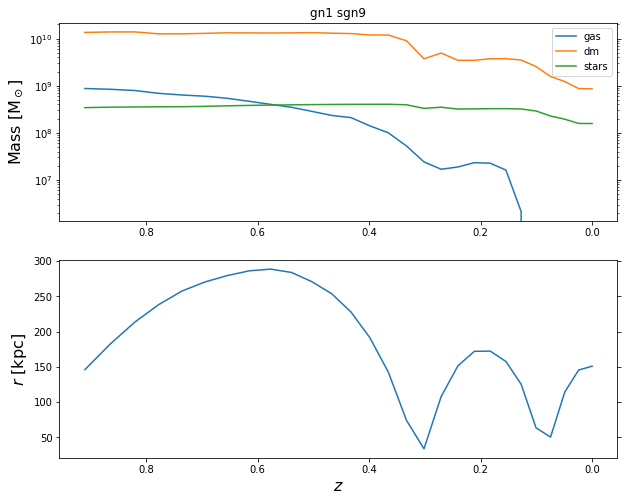

In [108]:
fig,ax = plt.subplots(nrows=2, figsize=(10,8))

ax[0].set_title('gn{} sgn{}'.format(gn,sgn))

ax[0].set_yscale('log')
ax[0].set_ylabel('Mass $[\mathrm{M_\odot}]$', fontsize=16)

ax[1].set_xlabel('$z$', fontsize=16)
ax[1].set_ylabel('$r$ [kpc]', fontsize=16)

ax[0].yaxis.set_ticks_position('both')
ax[1].yaxis.set_ticks_position('both')

ax[0].invert_xaxis()
ax[1].invert_xaxis()

for pt,l in zip([0,1,4],['gas', 'dm', 'stars']):
    ax[0].plot(z, masses[:,pt], label=l)
    
ax[0].legend()

ax[1].plot(z, np.linalg.norm(d, axis=1))

# Save figure:

filename = 'satellite_mass_evol_gn{}sgn{}_{}.png'.format(gn,sgn,sim_id)

home = os.path.dirname(snapshot_obj.__file__)
path = os.path.join(home,"Figures",sim_id)

# If the directory does not exist, create it
if not os.path.exists(path):
    os.makedirs(path)
plt.savefig(os.path.join(path,filename), dpi=200)